<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Assignment-Prompt" data-toc-modified-id="Assignment-Prompt-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Assignment Prompt</a></span><ul class="toc-item"><li><span><a href="#Import-and-Visualize-the-Training-and-Test-Data" data-toc-modified-id="Import-and-Visualize-the-Training-and-Test-Data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import and Visualize the Training and Test Data</a></span></li><li><span><a href="#Grading-Criteria" data-toc-modified-id="Grading-Criteria-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Grading Criteria</a></span></li><li><span><a href="#Grading-Rubric" data-toc-modified-id="Grading-Rubric-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Grading Rubric</a></span></li></ul></li><li><span><a href="#Analysis-Approach" data-toc-modified-id="Analysis-Approach-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analysis Approach</a></span><ul class="toc-item"><li><span><a href="#Fundamental-Approach" data-toc-modified-id="Fundamental-Approach-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Fundamental Approach</a></span></li><li><span><a href="#Choosing-Hyperparameters" data-toc-modified-id="Choosing-Hyperparameters-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Choosing Hyperparameters</a></span></li></ul></li><li><span><a href="#Basic-Trends/Exploratory-Analysis" data-toc-modified-id="Basic-Trends/Exploratory-Analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Basic Trends/Exploratory Analysis</a></span></li><li><span><a href="#Kernel-Structure" data-toc-modified-id="Kernel-Structure-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Kernel Structure</a></span><ul class="toc-item"><li><span><a href="#Kernel-Contributions" data-toc-modified-id="Kernel-Contributions-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Kernel Contributions</a></span><ul class="toc-item"><li><span><a href="#Initial-Parameter-Estimates" data-toc-modified-id="Initial-Parameter-Estimates-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Initial Parameter Estimates</a></span></li></ul></li><li><span><a href="#Final-Kernel" data-toc-modified-id="Final-Kernel-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Final Kernel</a></span></li></ul></li><li><span><a href="#Fitting-of-Kernel-Hyperparameters" data-toc-modified-id="Fitting-of-Kernel-Hyperparameters-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Fitting of Kernel Hyperparameters</a></span><ul class="toc-item"><li><span><a href="#MAP-Hyperparameter-Inference" data-toc-modified-id="MAP-Hyperparameter-Inference-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>MAP Hyperparameter Inference</a></span><ul class="toc-item"><li><span><a href="#The-MAP-approach" data-toc-modified-id="The-MAP-approach-5.1.1"><span class="toc-item-num">5.1.1&nbsp;&nbsp;</span>The MAP approach</a></span></li><li><span><a href="#Gradient-Descent-Method" data-toc-modified-id="Gradient-Descent-Method-5.1.2"><span class="toc-item-num">5.1.2&nbsp;&nbsp;</span>Gradient Descent Method</a></span></li><li><span><a href="#MAP-implementation" data-toc-modified-id="MAP-implementation-5.1.3"><span class="toc-item-num">5.1.3&nbsp;&nbsp;</span>MAP implementation</a></span><ul class="toc-item"><li><span><a href="#Partial-Derivatives-of-Logp" data-toc-modified-id="Partial-Derivatives-of-Logp-5.1.3.1"><span class="toc-item-num">5.1.3.1&nbsp;&nbsp;</span>Partial Derivatives of Logp</a></span></li><li><span><a href="#Defining-Python-Methods-for-Logp-and-the-Gradient-of-Logp" data-toc-modified-id="Defining-Python-Methods-for-Logp-and-the-Gradient-of-Logp-5.1.3.2"><span class="toc-item-num">5.1.3.2&nbsp;&nbsp;</span>Defining Python Methods for Logp and the Gradient of Logp</a></span></li><li><span><a href="#Optimization-with-SciPy-Optimize" data-toc-modified-id="Optimization-with-SciPy-Optimize-5.1.3.3"><span class="toc-item-num">5.1.3.3&nbsp;&nbsp;</span>Optimization with SciPy Optimize</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Posterior-Predictive-Distribution-y*" data-toc-modified-id="Posterior-Predictive-Distribution-y*-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Posterior Predictive Distribution y*</a></span><ul class="toc-item"><li><span><a href="#Posterior-Predictive-Function" data-toc-modified-id="Posterior-Predictive-Function-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Posterior Predictive Function</a></span></li><li><span><a href="#Prediction-Using-RW-parameters" data-toc-modified-id="Prediction-Using-RW-parameters-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Prediction Using RW parameters</a></span></li><li><span><a href="#Final-Plot" data-toc-modified-id="Final-Plot-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Final Plot</a></span></li></ul></li><li><span><a href="#References" data-toc-modified-id="References-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>References</a></span></li></ul></div>

# Building Your Own Gaussian Process Model

Class: AE8803 - Machine Learning with Gaussian Processes

Due Date: March 15th, 2024 | 21:00 PST on Canvas

Author: Theodore Wilkening | https://github.com/twilkening

## Assignment Prompt

Based off of the Mauna Loa CO2 dataset.

Per the assignment prompt:

"This assignment requires you to fit a Gaussian process model to the Mauna Loa data set. It is a univariate dataset that comprises the monthly average carbon dioxide concentration, measured in parts per million.

You will find the data at this [site](https://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record.html). You will have to download the `monthly_in_situ_co2_mlo.csv` file directly. Details about the data can be found in reference 1.

The plot below shows the data: year vs. CO2 (ppm). Some rows of the table have -99.99 values; these may be ignored. Note that as there are 12 measurements per year (1 for each month), utilizing just the year as the covariate is not appropriate, and that is why the “Date” or third column must be used.

Your training data must be limited to all years before 2014, i.e., you may only use CO2 concentrations in the years 1958 to 2013. It is entirely your decision whether you wish to use all this data, or select a subset."

### Import and Visualize the Training and Test Data

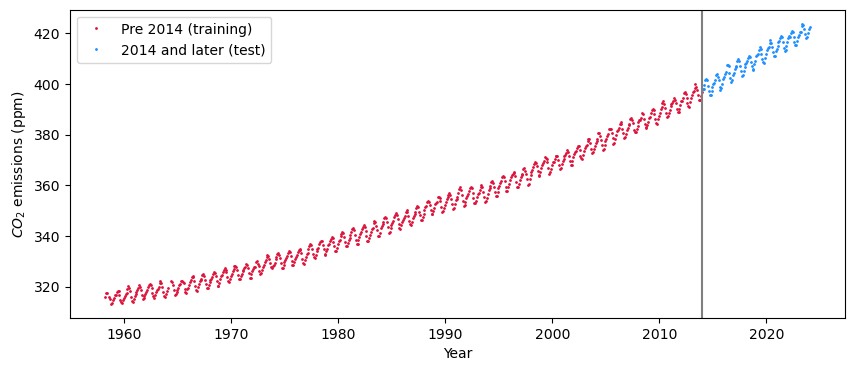

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy

# read in and clean the data:
df = pd.read_csv('monthly_in_situ_co2_mlo.csv',skiprows=64,header=None)
df.drop([0,1,2,5,6,7,8,9,10],axis=1,inplace=True)
df.columns = ["Date","CO2"]
df = df[df['CO2']> 0]

# visualize training vs test data
df2014 = df[df['Date']< 2014]
dfnew = df[df['Date']>= 2014]

fig = plt.figure(figsize=(10,4))
plt.plot(df2014['Date'].values, df2014['CO2'].values, 'o', ms=1, color='crimson', label='Pre 2014 (training)')
plt.plot(dfnew['Date'].values, dfnew['CO2'].values, 'o', ms=1, color='dodgerblue', label='2014 and later (test)')
plt.legend()
plt.axvline(x=2014, color="grey")
plt.xlabel('Year')
plt.ylabel(r'$CO_2$ emissions (ppm)')
plt.show()

### Grading Criteria

- Appropriate importing of the data and filtering of non-relevant rows. I will run your code on the “.csv” file as provided on the Scripps website. You cannot submit your amended version of the data.
- Use of multiple kernel functions, justifying what exactly each kernel is doing.
- A well-documented Jupyter notebook with equations for all the relevant formulas and code. If your code does not run, or produces an error upon running, you will loose a lot of marks.
- One approach for hyperparameter inference (e.g., maximum likelihood, cross validation, Markov chain Monte Carlo, etc.). Please note that the signal noise need not be optimized over (but can be if you wish).
- You will have to analytically calculate any gradients for hyperparameter inference. To clarify, code that does not use gradients, or code where the gradients are incorrect, will not receive full marks. To check your gradients you can always use finite differences.
- You are restricted to the following libraries: numpy, seaborn, matplotlib, scipy, pandas. Thus, you will have to build a lot of the codebase yourself.
- The last plot in your submission should have the same data as the plot above (both pre- and post-), along with predictive posterior mean and standard deviation contours.

### Grading Rubric

- Data importing [5]
- GP model architecture (i.e. kernels) [5]
- Hyperparameter inference [10]
- Clarity of documentation [5]

## Analysis Approach

### Fundamental Approach

The fundamental approach we will take in our analysis is to find **most likely** values of CO2 concentration given the training data set, and the new test points we would like to predict. That is, in math equations:

$$
\begin{aligned}
\mathbb{E} \left[ \mathbf{y}_{\ast} | \mathbf{X}_{\ast}, \mathbf{X}, \mathbf{y}  \right] & = \mathbf{K}\left( \mathbf{X}_{\ast}, \mathbf{X} \right) \left[\mathbf{K}\left( \mathbf{X}, \mathbf{X} \right) + \sigma_{n}^2 \mathbf{I} \right]^{-1} \mathbf{y} \\
Covar\left[ \mathbf{y}_{\ast} | \mathbf{X}_{\ast}, \mathbf{X}, \mathbf{y} \right] & = \mathbf{K}\left( \mathbf{X}_{\ast}, \mathbf{X}_{\ast} \right) - \mathbf{K}\left( \mathbf{X}_{\ast}, \mathbf{X} \right) \left[\mathbf{K}\left( \mathbf{X}, \mathbf{X} \right) + \sigma_{n}^2 \mathbf{I} \right]^{-1} \mathbf{K}\left( \mathbf{X}, \mathbf{X}_{\ast} \right) + \sigma_{n_*}^2 I
\end{aligned}
$$

To provide a brief background on how we arrived at the above, we observe the following. Assuming the underlying distributions are 0-mean Gaussian, we can write the joint Gaussian distribution as:

$$\begin{pmatrix} y \\ f_* \end{pmatrix} \sim 
\mathcal{N} \left( 
                \begin{bmatrix} 0 \\ 0 \end{bmatrix},
                \begin{bmatrix} K(X,X) + \sigma_n^2 I & K(X,X_*) \\ K(X_*,X) & K(X_*,X_*) \end{bmatrix}
            \right)$$
            
Where $\sigma_n^2 I$ arises from the measurement noise and $K(X,X')$ is the variance of the underlying Bayesian linear regression model. That is,

$$
y = f(X) + \epsilon,\\
    \text{where}\ f(X) = \Phi(X)^T \mathcal{w}\\
    \epsilon \sim \mathcal{N}(0,\sigma_n^2I)\ 
        \text{and}\ \mathcal{w} \sim \mathcal{N}(0, \Sigma_p)
$$

Such that:

$$
\begin{aligned}
\mathbb{E}[f(X)] &= \Phi(X)^T \mathbb{E}[\mathcal{w}] = 0\\
\mathbb{E}[f(X)f(X')^T] &= \Phi(X)^T\mathbb{E}[\mathcal{w}\mathcal{w}^T] \Phi(X) = K(X,X')
\end{aligned}
$$

Thus we understand that by defining the *positive definite* "kernel" $K(X,X')$, we are implicitly defining the set of feature vectors $\Phi(X)$, which may be infinite (per Mercer's Theorem), and a 0-mean Gaussian prior. [11]  As $K(X,X')$ is a covariance function that we design to implicitly define the feature vectors and prior, we note that it must be positive definite.

Now, from the joint Gaussian distribution above, it follows based on the definition of the conditional for a multivariate Gaussian that we have: [6]

$$
\begin{aligned}
\mathbb{E} \left[ \mathbf{f}_{\ast} | \mathbf{X}_{\ast}, \mathbf{X}, \mathbf{y}  \right] & = \mathbf{K}\left( \mathbf{X}_{\ast}, \mathbf{X} \right) \left[\mathbf{K}\left( \mathbf{X}, \mathbf{X} \right) + \sigma_{n}^2 \mathbf{I} \right]^{-1} \mathbf{y} \\
Covar\left[ \mathbf{f}_{\ast} | \mathbf{X}_{\ast}, \mathbf{X}, \mathbf{y} \right] & = \mathbf{K}\left( \mathbf{X}_{\ast}, \mathbf{X}_{\ast} \right) - \mathbf{K}\left( \mathbf{X}_{\ast}, \mathbf{X} \right) \left[\mathbf{K}\left( \mathbf{X}, \mathbf{X} \right) + \sigma_{n}^2 \mathbf{I} \right]^{-1} \mathbf{K}\left( \mathbf{X}, \mathbf{X}_{\ast} \right)
\end{aligned}
$$

and, since we have $y = f(x) + \epsilon$:

$$
\begin{aligned}
\mathbb{E} \left[ \mathbf{y}_{\ast} | \mathbf{X}_{\ast}, \mathbf{X}, \mathbf{y}  \right] & = \mathbf{K}\left( \mathbf{X}_{\ast}, \mathbf{X} \right) \left[\mathbf{K}\left( \mathbf{X}, \mathbf{X} \right) + \sigma_{n}^2 \mathbf{I} \right]^{-1} \mathbf{y} \\
Covar\left[ \mathbf{y}_{\ast} | \mathbf{X}_{\ast}, \mathbf{X}, \mathbf{y} \right] & = \mathbf{K}\left( \mathbf{X}_{\ast}, \mathbf{X}_{\ast} \right) - \mathbf{K}\left( \mathbf{X}_{\ast}, \mathbf{X} \right) \left[\mathbf{K}\left( \mathbf{X}, \mathbf{X} \right) + \sigma_{n}^2 \mathbf{I} \right]^{-1} \mathbf{K}\left( \mathbf{X}, \mathbf{X}_{\ast} \right) + \sigma_{n_*}^2 I
\end{aligned}
$$

**Thus, our main focus will be on defining appropriate kernels and measurement noise to capture the behavior of the system so that we have the most accurate posterior predictive model possible.**

### Choosing Hyperparameters

In order to choose an appropriate kernel, we note some of the following common kernels and describe the type of behavior they might model given the hyperparameters. See Rasmussen & Williams' book "Gaussian Processes for Machine Learning" for more information and a broader list. [12]

**Squared Exponential (SE):**

The length scale is proportional to the number of times a Gaussian Process (GP) will cross the 0-mark over a period where $x-x' = 1$. The SE is also infinitely differentiable, meaning it is a very smooth GP. Thus we can use the SE kernel to describe noisy processes, or very long and smooth processes that we expect to return to the mean over time.

$\theta_1$ is the amplitude, $\theta_2$ represents the length-scale.

$$k_1 (x,x') = \theta_1 ^2 \exp \left(- \frac{(x-x')^2}{2 \theta_2 ^2} \right) $$

**Periodic:**

The behavior of this function is relatively self-explanatory. See Rasmussen & Williams for a more in-depth description of how this is derived from a cosine and since function combined with the SE. [14] 

$\theta_4$ is the amplitude, $\theta_5$ represents the length-scale.

$$k_2 (x,x') = \theta_3 ^2 \exp \left(- \frac{2 \sin^2 \left(\pi(x-x')\right)}{\theta_5 ^2} \right)$$

**Rational Quadratic:**

Rasmussen & Williams note about the rational quadratic kernel that it "can be seen as a scale mixture (an infinite sum) of squared exponential (SE) covariance functions with different characteristic length-scales." [13] 

$\theta_6$ is the amplitude, $\theta_7$ represents the length-scale, and $\theta_8$ parameterizes the *spread* of the length-scales of the underlying SE covariance functions the rational quadratic kernel represents.

$$k_3 (x,x') = \theta_6 ^2 \left(1 + \frac{(x-x')^2}{2 \theta_7 ^2 \theta_8} \right)^{-\theta_8} $$


Now that we have some potential kernel *structures*, the hard part will be choosing the *hyperparameters* $\theta$ for each of the kernel functions we elect for our model. 

One method for approaching this problem is the Maximum a Posteriori (MAP) estimate, which attempts to find an estimate for the maximum likelihood of $\theta | y,X$. A second method is the Markov Chain Monte Carlo method, which attempts to numerically populate the probability distributions of each of the hyperparameters that would lead to the maximum likelihood of $\theta | y,X$.

In our report we will lean on the MAP, as seen in section 5 "Fitting of Kernel Hyperparameters."

## Basic Trends/Exploratory Analysis

To inform our choices of kernels, we note that there are some obvious trends we can see by observing the initial plot in Section 1.1 "Import and Visualize the Training and Test Data". Specifically, we notice that there is a significant yearly trend around a gently rising major trend. To gain insight on the yearly trend, we plot the CO2 levels over the course of a year for several years:

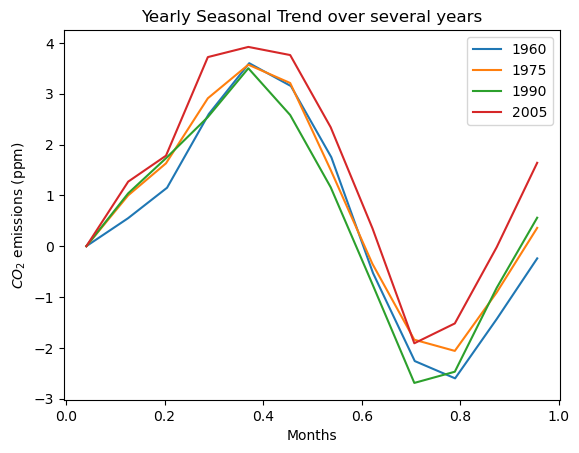

In [2]:
fig = plt.figure()
years = np.arange(1960,2010+1,15)
for i in range(0,len(years)):
    data = df[(df['Date'] >= years[i]) & (df['Date'] < years[i] + 1)]
    lbl = str(years[i])
    # set x-axis to months
    months = data['Date'].values - years[i]
    # normalize data to the beginning of the year:
    co2 = data['CO2'].values - data['CO2'].values[0]
    plt.plot(months, co2,ms=0.75,label=lbl)
    
plt.legend()
plt.xlabel('Months')
plt.ylabel(r'$CO_2$ emissions (ppm)')
plt.title('Yearly Seasonal Trend over several years')
plt.show()


We also notice a slight medium-term irregularity and that the training data does not only have a seasonal trend, but something like a decadal trend. In the plot below, we include grid lines for easier visualization of the slight perturbations on a decadal level, around the major trend.

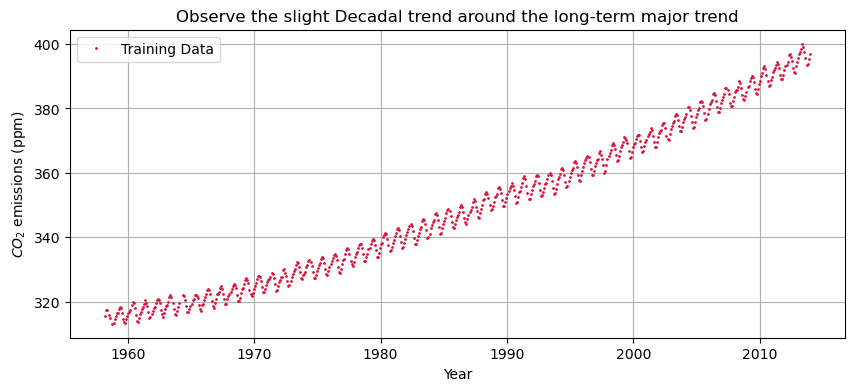

In [3]:
fig = plt.figure(figsize=(10,4))
plt.plot(df2014['Date'].values, df2014['CO2'].values, 'o', ms=1, color='crimson', label='Training Data')
plt.legend()
# plt.axvline(x=1991.5, color="grey")
plt.grid()
plt.xlabel('Year')
plt.ylabel(r'$CO_2$ emissions (ppm)')
plt.title('Observe the slight Decadal trend around the long-term major trend')
plt.show()

## Kernel Structure

### Kernel Contributions

In this section we describe the kernels that are chosen to model the four basic trends described in the previous section. The kernels and the reasoning are effectively copied from Rasmussen & Williams book, Gaussian Process for Machine Learning [7].

1. Major trend.
    - The major trend here is a long term, smoothly rising trend in the atmospheric CO2 concentration level. To model this, we choose a Squared Exponential function, which if the parameters are learned correctly (correct amplitude and length scale), will pick up the smooth trend in the data.

$$k_1 (x,x') = \theta_1 ^2 \exp \left(- \frac{(x-x')^2}{2 \theta_2 ^2} \right) $$
    
2. Seasonal (yearly) trend.
    - Rasmussen and Williams talk about how the seasonal growth and decay of plant matter contributes to the atmospheric CO2 in the Mauna Loa region. Based on the plots shown above, we can see that they have a very consistent yearly periodic trend. However, it appears that the trend is not perfect, so a squared exponential term is multiplied with the periodic term. This effectively introduces a decay of the periodic impacts on the prediction. If $\theta_4$ turns out to be very large after fitting the hyperparameters, then the decay term will not have a big effect on the periodic trend.
    - In the expression below, note that the periodic term is defined to have a constant period of 1 year.

$$k_2 (x,x') = \theta_3 ^2 \exp \left(- \frac{(x-x')^2}{2 \theta_4 ^2} - \frac{2 \sin^2 \left(\pi(x-x')\right)}{\theta_5 ^2} \right)$$

3. Medium term irregularities.
    - In the model we can see that the CO2 concentration peaks higher in some years than the year following, such as in ~1992 and ~2000. To model irregularities like this, we introduce a rational quadratic term, as recommended by Rasmussen and Williams. In their analysis, the rational quadratic kernel performed better than the simpler squared exponential kernel. They explain this is likely due to the rational quadratic kernel representing a bunch of squared-exponential length-scales.

$$k_3 (x,x') = \theta_6 ^2 \left(1 + \frac{(x-x')^2}{2 \theta_7 ^2 \theta_8} \right)^{-\theta_8} $$

4. Short-term noise.
    - To model the short-term noise, we choose a squared-exponential kernel. We will expect the amplitude and length scale of this kernel to end up relatively small compared to the amplitudes of the Major, Seasonal and Medium trend amplitudes.
    
$$k_4 (x,x') = \theta_9 ^2 \exp \left(- \frac{(x-x')^2}{2 \theta_{10}^2} \right) $$

5. Measurement noise.
    - Finally, we model the measurement noise. This is independent noise added to accomodate noise in the measurement instruments.
    
$$k_5 (x_p, x_q) = \theta_{11}^2 \delta_{pq}$$

$$\Rightarrow K_5 = \theta_{11}^2 I_n,\ \text{where}\ n=\text{# of training data points}$$


In [4]:
def tiled_difference(xa, xb):
    m, n = len(xa), len(xb)
    xa, xb = xa.reshape(m,1) , xb.reshape(1,n)
    X = np.tile(xa,(1,n)) - np.tile(xb,(m,1))
    return X

def K1(x,xp,th1,th2):
    xdiff = tiled_difference(x.astype(float),xp.astype(float))
    K = th1**2 * np.exp(-(xdiff)**2 / (2* th2**2))
    return K

def K2(x,xp,th3,th4,th5):
    xdiff = tiled_difference(x.astype(float),xp.astype(float))
    K = th3**2 * np.exp(-(xdiff)**2 / (2* th4**2) \
                           - 2* np.sin(np.pi * (xdiff))**2/(th5**2))
    return K

def K3(x,xp,th6,th7,th8):
    xdiff = tiled_difference(x.astype(float),xp.astype(float))
    K = th6**2 * (1 + (xdiff)**2 / (2* th7**2 * th8))**(-th8)
    return K

def K4(x,xp,th9,th10):
    xdiff = tiled_difference(x.astype(float),xp.astype(float))
    K = th9**2 * np.exp(-(xdiff)**2 / (2* th10**2))
    return K

def K5(x,xp,th11):
    K = tiled_difference(x.astype(float),xp.astype(float))
    K[np.where(K!=0)] = 2
    K[np.where(K==0)] = 1
    K[np.where(K!=1)] = 0
    return th11**2 * K

#### Initial Parameter Estimates

Based on the above Kernels, we can estimate approximately what the hyperparameters should be. This will help to give some good starting guess values when we perform the MAP. Note in the plot below that we subtract the mean of the training data from the data set in order to get a more accurate model prediction later on. We will not visualize kernel 4 or kernel 5 since they simply represent noise. We can adequately guess their amplitude and length scale to be < 1.

In [5]:
# setting data values for plotting:
x = df2014['Date'].values
y = df2014['CO2'].values
theta_init = np.array([50,50,3.5,70,1.5,1,4,5,0.5,0.5,0.5])

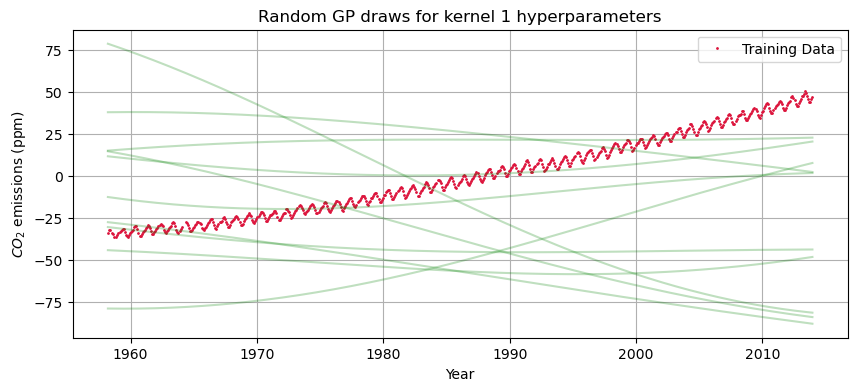

In [6]:
# plot K1
fig = plt.figure(figsize=(10,4))
plt.plot(x, y - y.mean(), 'o', ms=1, color='crimson', label='Training Data')
kern1 = K1(x,x,theta_init[0],theta_init[1])
k1pdf = np.random.multivariate_normal(np.zeros(len(x)),kern1,10)
plt.plot(x,k1pdf.T,'g',alpha=0.25)

plt.grid()
plt.xlabel('Year')
plt.ylabel(r'$CO_2$ emissions (ppm)')
plt.title('Random GP draws for kernel 1 hyperparameters')
plt.legend()
plt.show()

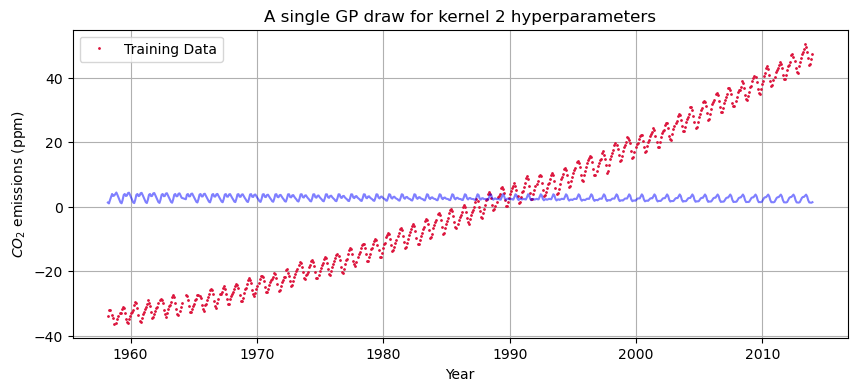

In [7]:
# plot K2
fig = plt.figure(figsize=(10,4))
plt.plot(x, y - y.mean(), 'o', ms=1, color='crimson', label='Training Data')
kern2 = K2(x,x,theta_init[2],theta_init[3],theta_init[4])
k2pdf = np.random.multivariate_normal(np.zeros(len(x)),kern2,1)
plt.plot(x,k2pdf.T,'b',alpha=0.5)

plt.grid()
plt.xlabel('Year')
plt.ylabel(r'$CO_2$ emissions (ppm)')
plt.title('A single GP draw for kernel 2 hyperparameters')
plt.legend()
plt.show()

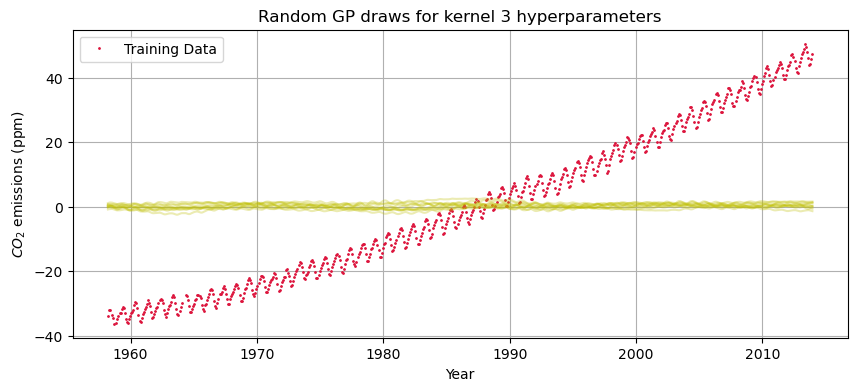

In [8]:
# plot K3
fig = plt.figure(figsize=(10,4))
plt.plot(x, y - y.mean(), 'o', ms=1, color='crimson', label='Training Data')
kern3 = K2(x,x,theta_init[5],theta_init[6],theta_init[7])
k3pdf = np.random.multivariate_normal(np.zeros(len(x)),kern3,10)
plt.plot(x,k3pdf.T,'y',alpha=0.3)

plt.grid()
plt.xlabel('Year')
plt.ylabel(r'$CO_2$ emissions (ppm)')
plt.title('Random GP draws for kernel 3 hyperparameters')
plt.legend()
plt.show()

### Final Kernel

The final kernel is computed as the sum of the previous five kernel functions:

$$k(x,x') = k_1(x,x') + k_2(x,x') + k_3(x,x') + k_4(x,x') + k_5(x,x')$$

In [9]:
def kernel(x,xp,theta):
    if theta.shape != (11,):
        raise AttributeError('Theta vector is not the correct shape. Must be (11,)')
    
    kern1 = K1(x,xp,theta[0],theta[1])
    kern2 = K2(x,xp,theta[2],theta[3],theta[4])
    kern3 = K3(x,xp,theta[5],theta[6],theta[7])
    kern4 = K4(x,xp,theta[8],theta[9])
    kern5 = K5(x,xp,theta[10])
    k = kern1 + kern2 + kern3 + kern4 + kern5
    
    return k

## Fitting of Kernel Hyperparameters

### MAP Hyperparameter Inference

layout the MAP equations and what we're going after.
show the partial derivatives of the kernel functions
explain how we're going to do the gradient descent for a multi-function non-linear problem, with notes on how to simplify the math that we're doing, since K is a positive definite matrix.

#### The MAP approach

In the maximum a posterior (MAP) hyperparameter inference technique, the goal is to find the most likely hyperparameters, given the measurements we have:

$$p(\theta|t) = \frac{p(t|\theta) p(\theta)}{p(t)}$$

Since the marginal likelihood $p(t) = \int p(t|\theta) p(\theta) d\theta$ is usually intractable, we look instead at an approximation of $p(\theta|t)$, noting that $p(t)$ is constant with respect to $\theta$. [9]

$$p(\theta|t) = \frac{p(t|\theta) p(\theta)}{p(t)} \propto p(t|\theta) p(\theta)$$

Now, we can find the maximum of $p(\theta|t)$ by investigating $\log p(\theta|t)$ and maximizing the result w.r.t. $\theta$. This is by definition the MAP estimate: [9]

$$\hat{\theta}_{MAP} = \underset{\theta}{argmax} \log{p(\theta|t)}= \underset{\theta}{argmax} \log{p(t|\theta)} + \log{p(\theta)}$$

where $p(\theta)$ is the prior of $\theta$ defined by the user.

Now, since we know that $p(t|\theta) \sim \mathcal{N}(t|0, C(\theta) + \sigma^2 I_N)$, we can write: [9]

$
\begin{align}
\log{p(t|\theta)} &= \log{\left[ (2 \pi)^{-N/2} |C + \sigma^2 I|^{-1/2} \exp \left( -\frac{1}{2} t^T (C + \sigma^2 I)^{-1} t \right) \right]} \\
&= -\frac{N}{2} \log{(2\pi)} -\frac{1}{2} \log{|C + \sigma^2 I|} - \frac{1}{2} t^T (C + \sigma^2 I)^{-1} t \\
&= -\frac{N}{2} \log{(2\pi)} -\sum_{i=1}^N \log{\mathbf{L}_{ii}} - \frac{1}{2} a^T a
\end{align}
$

where $S = C + \sigma^2 I = L L^T$ (Cholesky decomposition of a PD matrix) and $t^T S^{-1} t = t^T L^{-T}L^{-1} t = (L^{-1}t)^T(L^{-1}t) = a^T a$.

<br>

To investigate $\underset{\theta}{argmax} \log{p(\theta|t)}$, we will use a gradient descent method.

<br>

For now, we assume that $p(\theta)$ is a uniform distribution such that $\log{p(\theta)}$ is constant and we have: [9]

$\begin{align}
\hat{\theta}_{MAP} &= \underset{\theta}{argmax} \log{p(\theta|t)}= \underset{\theta}{argmax} \log{p(t|\theta)} + \log{constant} \\
&\propto \underset{\theta}{argmax} \log{p(t|\theta)}
\end{align}$

Thus we only have to investigate the gradient descent of $\log{p(t|\theta)}$.

#### Gradient Descent Method

Based on the Wikipedia article [Gradient Descent](https://en.wikipedia.org/wiki/Gradient_descent), we know that the basic gradient descent algorithm requires us to compute the gradient of the optimization function. In our case, the optimization function $F$ is multivariate function $\log p(t|\theta)$ and the gradient is a vector given by $\nabla_\theta \log p(t|\theta)$

In Rasmussen & Williams' book, they have provided the equation for the partial derivatives of $\log{p(t|\theta)}$ w.r.t. each hyperparameter $\theta_j$, shown below: [10]

$$\frac{\partial}{\partial \theta_j} \log{p(y|X,\theta)} = \frac{1}{2} y^T K^{-1} \frac{\partial K}{\partial\theta_j} K^{-1} y - \frac{1}{2} tr\left(K^{-1} \frac{\partial K}{\partial\theta_j} \right) \\
= \frac{1}{2} tr\left( (\alpha \alpha^T - K^{-1}) \frac{\partial K}{\partial\theta_j} \right)$$

where $y = t$, $\alpha = K^{-1} y$ and $K = K(x,x')$, the kernel. Note that Rasmussen and Williams explicitly include X since it is necessary for computation of the kernel.

For the optimization, we will use the SciPy function `scipy.optimize.minimize` and pass it $F = -\log p(t\theta)$ and $\nabla F = - \nabla_\theta \log p(t|\theta)$, since the function is built to optimize for a *minimum.*

#### MAP implementation

##### Partial Derivatives of Logp

Closed form representation of $\frac{\partial}{\partial \theta_j} \log{p(y|X,\theta)}$, which in turn relies on having a closed form solution of $\frac{\partial K}{\partial\theta_j}$. With regards to the latter, we have, for each element of the matrix $\frac{\partial K}{\partial\theta_j}$:

$
\begin{align}
\frac{\partial k(x,x')}{\partial\theta_1} &= 
        2 \theta_1 \exp \left( -\frac{1}{2} \frac{(x-x')^2}{2 \theta_2 ^2}\right) \\
\frac{\partial k(x,x')}{\partial\theta_2} &= 
        \theta_1 ^2 \exp \left( -\frac{1}{2} \frac{(x-x')^2}{2 \theta_2 ^2}\right)
            \left( \frac{(x-x')^2}{\theta_2 ^3} \right) \\
\frac{\partial k(x,x')}{\partial\theta_3} &= 
        2 \theta_3 \exp \left( -\frac{1}{2} \frac{(x-x')^2}{2 \theta_4 ^2} - 
            \frac{2 \sin^2\left(\pi(x-x')\right)}{\theta_5^2}\right) \\
\frac{\partial k(x,x')}{\partial\theta_4} &= 
        \theta_3^2 \exp \left( -\frac{1}{2} \frac{(x-x')^2}{2 \theta_4 ^2} - 
            \frac{2 \sin^2\left(\pi(x-x')\right)}{\theta_5^2}\right) 
            \left( \frac{(x-x')^2}{\theta_4 ^3} \right)\\
\frac{\partial k(x,x')}{\partial\theta_5} &= 
        \theta_3^2 \exp \left( -\frac{1}{2} \frac{(x-x')^2}{2 \theta_4 ^2} - 
            \frac{2 \sin^2\left(\pi(x-x')\right)}{\theta_5^2}\right) 
            \left( \frac{4 \sin^2\left(\pi(x-x')\right)}{\theta_5^3} \right)\\
\frac{\partial k(x,x')}{\partial\theta_6} &= 
        2 \theta_6 \left( 1 + \frac{(x-x')^2}{2 \theta_7 ^2 \theta_8}\right)^{-\theta_8} \\
\frac{\partial k(x,x')}{\partial\theta_7} &= 
        \theta_6^2 \left( 1 + \frac{(x-x')^2}{2 \theta_7 ^2 \theta_8}\right)^{-\theta_8 - 1}
            \left( \frac{(x-x')^2}{\theta_7 ^3} \right)\\
\frac{\partial k(x,x')}{\partial\theta_8} &= 
        \theta_6^2 \left( 1 + \frac{(x-x')^2}{2 \theta_7 ^2 \theta_8}\right)^{-\theta_8}
            \left( \frac{(x-x')^2}{2 \theta_7 ^2 \theta_8 + (x-x')^2} - 
            \log{\left(1 + \frac{(x-x')^2}{1 \theta_7 ^2 \theta_8}\right)} \right)\\
\frac{\partial k(x,x')}{\partial\theta_9} &= 
        2 \theta_9 \exp \left( -\frac{1}{2} \frac{(x-x')^2}{2 \theta_{10} ^2}\right) \\
\frac{\partial k(x,x')}{\partial\theta_{10}} &= 
        \theta_9^2 \exp \left( -\frac{1}{2} \frac{(x-x')^2}{2 \theta_{10} ^2}\right) 
            \left( \frac{(x-x')^2}{\theta_{10} ^3} \right) \\
\frac{\partial k(x,x')}{\partial\theta_{11}} &= 
        2 \theta_{11} \delta_{pq}
\end{align}
$

##### Defining Python Methods for Logp and the Gradient of Logp

Using a similar setup for the partial derivative kernels as developed in Section "Kernel Contributions", we can then define the following methods:

In [10]:
# defining the partial derivative matrices:
def Kpartial(x,xp,theta,i):
    xdiff = tiled_difference(x.astype(float),xp.astype(float))
    if i == 0:
        Kpartial = 2*theta[0] * np.exp(-(xdiff)**2 / (2* theta[1]**2))
    elif i == 1:
        Kpartial = theta[0]**2 * np.exp(-(xdiff)**2 / (2* theta[1]**2)) \
                        * ((xdiff)**2 / (theta[1]**3))
    elif i == 2:
        Kpartial = 2*theta[2] * np.exp(-(xdiff)**2 / (2* theta[3]**2) \
                                - 2* np.sin(np.pi * (xdiff))**2/(theta[4]**2))
    elif i == 3:
        Kpartial = theta[2]**2 * np.exp(-(xdiff)**2 / (2* theta[3]**2) \
                                - 2* np.sin(np.pi * (xdiff))**2/(theta[4]**2)) \
                        * ((xdiff)**2 / (theta[3]**3))
    elif i == 4:
        Kpartial = theta[2]**2 * np.exp(-(xdiff)**2 / (2* theta[3]**2) \
                                - 2* np.sin(np.pi * (xdiff))**2/(theta[4]**2)) \
                        * (4* np.sin(np.pi * (xdiff))**2/(theta[4]**3))
    elif i == 5:
        Kpartial = 2*theta[5] * (1 + (xdiff)**2 / (2* theta[6]**2 * theta[7]))**(-theta[7])
    elif i == 6:
        Kpartial = theta[5]**2 * (1 + (xdiff)**2 / (2* theta[6]**2 * theta[7]))**(-theta[7] - 1) \
                        * ((xdiff)**2 / theta[6]**3)
    elif i == 7:
        Kpartial = theta[5]**2 * (1 + (xdiff)**2 / (2* theta[6]**2 * theta[7]))**(-theta[7]) \
                        * (xdiff**2/(2*theta[7]*theta[6]**2) - \
                                   np.log(1 + xdiff**2/(2*theta[7]*theta[6]**2)))
    elif i == 8:
        Kpartial = 2*theta[8] * np.exp(-(xdiff)**2 / (2* theta[9]**2))
    elif i == 9:
        Kpartial = theta[8]**2 * np.exp(-(xdiff)**2 / (2* theta[9]**2)) \
                        * (xdiff**2/(theta[9]**2))
    elif i == 10:
        Kpartial = xdiff
        Kpartial[np.where(Kpartial!=0)] = 2
        Kpartial[np.where(Kpartial==0)] = 1
        Kpartial[np.where(Kpartial!=1)] = 0
        Kpartial = 2*theta[10] * Kpartial
    else:
        raise AttributeError('i must be in range 0-10')
    
    return Kpartial

# define G(theta)
def Grad(theta,x,xp,y):
    # compute alpha = K^-1 y
    Kxx = kernel(x,xp,theta)
    Kxx_inv = np.linalg.inv(Kxx)
    alpha = Kxx_inv @ y
    # compute alpha*alpha^T + K^-1
    Kmid = alpha @ alpha.T + Kxx_inv
    # initialize vector G of same size as theta^T
    G = np.zeros(theta.shape)
    for i in range(0,len(theta)):
        # compute the partial derivative of K w.r.t. Theta_i
        dK_i = Kpartial(x,xp,theta,i)
        
        # instead of calculating the trace of the matrix, less computations to only
        # compute the sum of the nth row * nth column. takes ~75% of matrix calc time
        dLogp_i = 0
        for n in range(0,len(x)):
            dLogp_i = dLogp_i + 1/2*(Kmid[n,:] @ dK_i[:,n])
        
        # # using matrix multiplication, optional
        # dLogp_i = 1/2 * np.trace(Kmid @ dK_i)
        
        # assign to G[i]
        G[i] = dLogp_i
    
    return G

# define the log p(y|X,theta) function, to evaluate
def logp(theta,x,xp,y):
    N = len(x)
    constant = -N/2 * np.log(2*np.pi)
    Kxx = kernel(x,x,theta)
    L = np.linalg.cholesky(Kxx)
    complexity = - sum(np.log(np.diag(L)))
    a = np.linalg.inv(L) @ y
    data_fit = -1/2 * a.T @ a
    return constant + complexity + data_fit

# define -G(theta)
def nGrad(theta,x,xp,y):
    return -Grad(theta,x,xp,y)

# define the -log p(y|X,theta) function
def nlogp(theta,x,xp,y):
    ll = logp(theta,x,xp,y)
    # per George documentation, scipy optimization doesn't play well with infinity
    return -ll if np.isfinite(ll) else 1e25

##### Optimization with SciPy Optimize

Given our intial guess for the vector of hyperparameters from section 4.1.1 "Initial Parameter Estimates" as the mean, we initially setup a uniform distribution +/-20% of $\theta_{init}$ to draw starting theta's from. However, this leads to some pretty dismal results as the MAP is not able to find a good set of hyperparameters. Thus, we will in addition use as the mean of the hyperparameter uniform distribution prior the values that were derived from Rasmussen & Williams' approach to the same problem. [15] Our uniform distribution will enapsulate +/-20% of these nominal values - effectively attempting to see if we can find any better set of hyperparameters.

After drawing intial guesses, we will then use the `scipy.optimize.minimize` function to find the maximum logp value. 

Wrapping this in a for loop, we will iterate through the optimization for 10 different random starting points of the hyperparameters.

###### Using Hyperparameter Prior from Initial Theta Guesses

In [11]:
x = df2014['Date'].values
mu_y = np.mean(df2014['CO2'].values)
y = df2014['CO2'].values - mu_y # centering values for better analysis
p = 10
logp_results = np.zeros(p)
theta_results = np.zeros((11,p))
for i in range(0,p):
    theta0 = theta_init * np.random.uniform(0.8,1.2,11)
    theta = scipy.optimize.minimize(nlogp,theta0,args=(x,x,y),jac=nGrad)
    logp_results[i] = -theta.fun # negative of nlogp
    theta_results[:,i] = theta.x


In [12]:
# combine the results into a dataframe for visualization
map_guess = pd.DataFrame(np.vstack((theta_results,logp_results)))
map_guess.insert(0,'Hyperparameter',['th1','th2','th3','th4','th5','th6','th7','th8','th9','th10','th11','logp'])
map_guess.set_index('Hyperparameter',inplace=True)
map_guess

,0,1,2,3,4,5,6,7,8,9
Hyperparameter,,,,,,,,,,
th1,43.143752,49.649891,47.333573,54.820998,53.921523,58.641065,44.351821,54.683837,46.777897,41.550149
th2,46.378453,55.639621,51.230507,54.796864,44.715534,50.105741,56.364578,58.822640,56.784932,41.933512
th3,3.668913,2.886853,3.981551,3.457118,3.265324,2.838864,4.022762,4.113149,2.961130,3.501709
th4,69.838473,81.463072,69.172920,67.312255,73.058131,62.286296,61.835801,75.903671,72.274994,76.453534
th5,1.676397,1.346567,1.588583,1.529295,1.301990,1.209119,1.788154,1.340155,1.398509,1.767908
th6,1.078029,1.055683,1.133623,0.871734,1.085810,0.995984,1.167836,0.843291,0.940554,0.846362
th7,3.456263,4.620201,3.664448,4.422115,3.821305,3.588152,4.791450,4.094256,3.503984,4.112409
th8,5.095864,5.661167,4.083085,5.269301,4.161856,5.836680,4.132838,5.421897,5.302203,4.456103
th9,0.543916,0.483563,0.418783,0.472185,0.530489,0.455036,0.558260,0.472757,0.464486,0.550885


In [13]:
# sort for the theta values that led to the maximum logp
theta_opt_guess = theta_results[:,np.argmax(logp_results)]
display("Estimated logp maximum is:", logp_results[np.argmax(logp_results)])
display("Estimated hyperparameters are:", theta_opt_guess)

'Estimated logp maximum is:'

-299.6117426734845

'Estimated hyperparameters are:'

array([41.55014852, 41.93351219,  3.50170873, 76.45353423,  1.76790757,
        0.84636228,  4.11240933,  4.4561026 ,  0.55088463,  0.5276039 ,
        0.40293769])

###### Using Hyperparameter Prior based on Rasmussen & Williams Solution

In [14]:
# initialize the logp and theta results vectors
theta_rw = np.array([66, 67, 2.4, 90, 1.3, 0.66, 1.2, 0.78, 0.18, 1.6/12, 0.19])

x = df2014['Date'].values
mu_y = np.mean(df2014['CO2'].values)
y = df2014['CO2'].values - mu_y # centering values for better analysis
p = 10
logp_results = np.zeros(p)
theta_results = np.zeros((11,p))
for i in range(0,p):
    theta0 = theta_rw * np.random.uniform(0.8,1.2,11)
    theta = scipy.optimize.minimize(nlogp,theta0,args=(x,x,y),jac=nGrad)
    logp_results[i] = -theta.fun # negative of nlogp
    theta_results[:,i] = theta.x


In [15]:
# combine the results into a dataframe for visualization
map_rw = pd.DataFrame(np.vstack((theta_results,logp_results)))
map_rw.insert(0,'Hyperparameter',['th1','th2','th3','th4','th5','th6','th7','th8','th9','th10','th11','logp'])
map_rw.set_index('Hyperparameter',inplace=True)
map_rw

,0,1,2,3,4,5,6,7,8,9
Hyperparameter,,,,,,,,,,
th1,75.826714,64.583448,61.755832,55.191135,67.408526,72.886872,75.681278,74.729640,55.566906,66.016951
th2,67.804419,62.461184,75.363504,57.828440,77.527424,66.981500,69.193328,77.288817,77.896209,62.835219
th3,2.341966,2.560557,2.495689,2.291131,1.944741,2.500679,2.084191,2.755485,2.339964,2.368149
th4,82.437814,87.827844,86.071226,107.551787,89.929608,84.861807,77.484338,86.755241,83.661322,82.359959
th5,1.386892,1.501802,1.042446,1.207730,1.314088,1.080384,1.415040,1.251872,1.474940,1.469779
th6,0.541926,0.572877,0.745089,0.564940,0.729164,0.678735,0.697163,0.662658,0.531753,0.662379
th7,1.009610,1.394852,1.214695,1.175977,1.337953,1.381796,1.143937,1.114276,1.368646,1.127678
th8,0.899335,0.801706,0.853348,0.911587,0.821080,0.895216,0.734969,0.671290,0.823323,0.628819
th9,0.178170,0.190603,0.183852,0.153433,0.206554,0.177321,0.173156,0.204225,0.159965,0.158563


In [16]:
# sort for the theta values that led to the maximum logp
theta_opt_rw = theta_results[:,np.argmax(logp_results)]
display("Estimated logp maximum is:", logp_results[np.argmax(logp_results)])
display("Estimated hyperparameters are:", theta_opt_rw)

'Estimated logp maximum is:'

-150.90369958943563

'Estimated hyperparameters are:'

array([67.40852575, 77.52742352,  1.94474093, 89.92960784,  1.31408779,
        0.72916363,  1.33795286,  0.82107959,  0.20655441,  0.1176701 ,
        0.18193509])

In [17]:
# comparing logp to value in RW book for theta values
x_rw = df[df['Date'] < 2004]['Date'].values
mu_y_rw = np.mean(df[df['Date'] < 2004]['Date'].values)
y_rw = df[df['Date'] < 2004]['Date'].values - mu_y_rw
logp2003 = logp(theta_rw,x_rw,x_rw,y_rw)
print('logp2003 calculated: ' + str(logp2003))
display('logp from RW: -108.5')

logp2003 calculated: 163.09754068742228


'logp from RW: -108.5'

I am not sure why our calculated `logp2003` is so much greater than the value reported in Rasmussen & Williams' book. Our equations for calculating $\log p(y|\theta,X)$ match those presented in the book. Something to investigate more later.

## Posterior Predictive Distribution y*

### Posterior Predictive Function

Code to calculate the posterior predictive distribution, inspired by Rasmussen & William's algorithm. [8]

Recall that we are implementing the following equations:

$$
\begin{aligned}
\mathbb{E} \left[ \mathbf{y}_{\ast} | \mathbf{X}_{\ast}, \mathbf{X}, \mathbf{y}  \right] & = \mathbf{K}\left( \mathbf{X}_{\ast}, \mathbf{X} \right) \left[\mathbf{K}\left( \mathbf{X}, \mathbf{X} \right) + \sigma_{n}^2 \mathbf{I} \right]^{-1} \mathbf{y} \\
Covar\left[ \mathbf{y}_{\ast} | \mathbf{X}_{\ast}, \mathbf{X}, \mathbf{y} \right] & = \mathbf{K}\left( \mathbf{X}_{\ast}, \mathbf{X}_{\ast} \right) - \mathbf{K}\left( \mathbf{X}_{\ast}, \mathbf{X} \right) \left[\mathbf{K}\left( \mathbf{X}, \mathbf{X} \right) + \sigma_{n}^2 \mathbf{I} \right]^{-1} \mathbf{K}\left( \mathbf{X}, \mathbf{X}_{\ast} \right) + \sigma_{n_*}^2 I
\end{aligned}
$$


In [18]:
def posterior_predictive(x,y,xnew,theta):
    # condition the inputs
    x = x.values
    y = y.values
    xnew = xnew.values
    # compute the mean and covariance
    Kxx = kernel(x,x,theta)
        # check if all the eigen values of the kernel are > 0
    if np.all(np.linalg.eigvals(Kxx) > 0) == False:
        print('eigen values were not > 0')
        m,n = Kxx.shape # should be square...
        Kxx = Kxx + 1e-9*np.eye(m,m) # adding a small value to deal with floating point errors
    L = np.linalg.cholesky(Kxx)
    alpha = np.linalg.inv(L.T) @ np.linalg.inv(L) @ y
    mean = kernel(xnew,x,theta) @ alpha
    v = np.linalg.inv(L) @ kernel(x,xnew,theta)
    # finally, compute covariance with added measurement noise
    cov = kernel(xnew,xnew,theta) - v.T @ v + K5(xnew,xnew,theta[10])
    n = len(y)
    marginal = -1/2 * y.T @ alpha - np.sum(np.log(np.diag(L))) - n/2 * np.log(2*np.pi)
    return mean, cov, marginal

### Prediction Using RW parameters

First let's try it with the RW parameters! Since we have the same kernel structure we can simply plug in RW parameters. [15]

In [19]:
x = df2014['Date']
mu_y = np.mean(df2014['CO2'].values)
y = df2014['CO2'] - mu_y # centering values for better analysis
xnew = dfnew['Date']
ynew = dfnew['CO2']
mu, cov, marg_like = posterior_predictive(x,y,xnew,theta_rw)
noise = theta_rw[10]
cov = cov + noise*np.eye(cov.shape[0])

<function matplotlib.pyplot.show(close=None, block=None)>

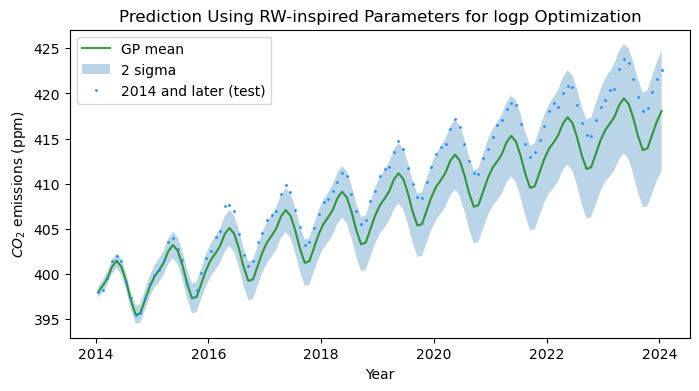

In [20]:
fig = plt.figure(figsize=(8,4))

# generate 50 new posterior predictive predictions
# fstar_rw = np.random.multivariate_normal(mu,cov,50) + mu_y
# plt.plot(xnew,fstar_rw.T,'g',alpha=0.1)
# plt.title('Random draws from the Posterior Predictive using RW parameters')

# plot the mean and the covariance at each xnew value:
ystar_rw_mean = mu + mu_y
plt.plot(xnew.values,ystar_rw_mean,color='g',alpha=0.75,label='GP mean')
plt.fill_between(xnew.values,ystar_rw_mean - 2*np.diag(cov),
                 ystar_rw_mean + 2*np.diag(cov),alpha=0.3,label='2 sigma')
plt.title('Prediction Using RW-inspired Parameters for logp Optimization')

# plot the test data:
plt.plot(xnew.values, ynew.values, 'o', ms=1, color='dodgerblue', label='2014 and later (test)')

plt.xlabel('Year')
plt.ylabel(r'$CO_2$ emissions (ppm)')
plt.legend()
plt.show

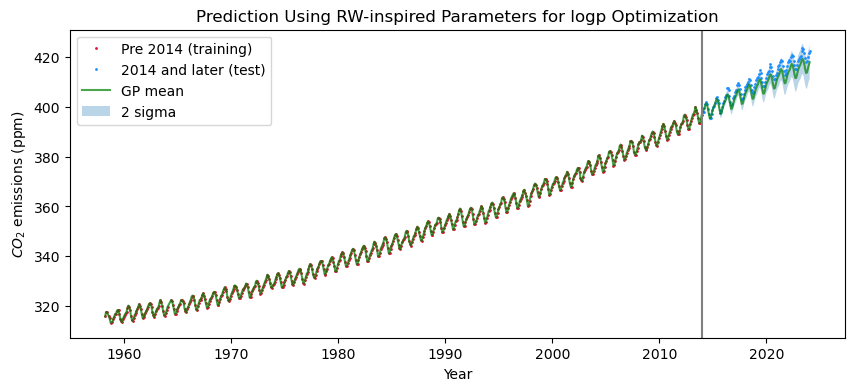

In [21]:
# plot for the whole data set:
# generate the Posterior Prediction Distribution:
x = df2014['Date']
mu_y = np.mean(df2014['CO2'].values)
y = df2014['CO2'] - mu_y # centering values for better analysis
xnew = dfnew['Date']
ynew = dfnew['CO2']
mu, cov, marg_like = posterior_predictive(x,y,df['Date'],theta_rw)
noise = theta_rw[10]
cov = cov + noise*np.eye(cov.shape[0])

fig = plt.figure(figsize=(10,4))
plt.plot(x.values, y.values + mu_y, 'o', ms=1, color='crimson', label='Pre 2014 (training)')
plt.plot(xnew.values, ynew.values, 'o', ms=1, color='dodgerblue', label='2014 and later (test)')
plt.plot(df['Date'].values,mu + mu_y,'g',alpha=0.7,label='GP mean')
plt.fill_between(df['Date'].values,mu + mu_y - 2*np.diag(cov),
                 mu + mu_y + 2*np.diag(cov),alpha=0.3,label='2 sigma')
plt.legend()
plt.axvline(x=2014, color="grey")
plt.xlabel('Year')
plt.ylabel(r'$CO_2$ emissions (ppm)')
plt.title('Prediction Using RW-inspired Parameters for logp Optimization')
plt.show()

### Final Plot

In [22]:
# generate the Posterior Prediction Distribution:
x = df2014['Date']
mu_y = np.mean(df2014['CO2'].values)
y = df2014['CO2'] - mu_y # centering values for better analysis
xnew = dfnew['Date']
ynew = dfnew['CO2']
mu, cov, marg_like = posterior_predictive(x,y,xnew,theta_opt_guess)
noise = theta_opt_guess[10]
cov = cov + noise*np.eye(cov.shape[0])

<function matplotlib.pyplot.show(close=None, block=None)>

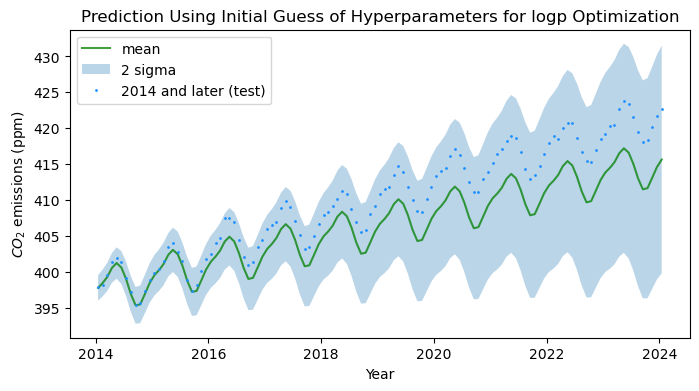

In [23]:
fig = plt.figure(figsize=(8,4))

# generate 50 new posterior predictive predictions
# fstar_rw = np.random.multivariate_normal(mu,cov,50) + mu_y
# plt.plot(xnew,fstar_rw.T,'g',alpha=0.1)
# plt.title('Random draws from the Posterior Predictive using RW parameters')

# plot the mean and the covariance at each xnew value:
plt.plot(xnew.values,mu + mu_y,color='g',alpha=0.75,label='mean')
plt.fill_between(xnew.values,mu + mu_y - 2*np.diag(cov),
                 mu + mu_y + 2*np.diag(cov),alpha=0.3,label='2 sigma')
plt.title('Prediction Using Initial Guess of Hyperparameters for logp Optimization')

# plot the test data:
plt.plot(xnew.values, ynew.values, 'o', ms=1, color='dodgerblue', label='2014 and later (test)')

plt.xlabel('Year')
plt.ylabel(r'$CO_2$ emissions (ppm)')
plt.legend()
plt.show

Plot for the whole data set:

In [24]:
# generate the Posterior Predictive Distribution:
x = df2014['Date']
mu_y = np.mean(df2014['CO2'].values)
y = df2014['CO2'] - mu_y # centering values for better analysis
xnew = dfnew['Date']
ynew = dfnew['CO2']
mu, cov, marg_like = posterior_predictive(x,y,df['Date'],theta_opt_guess)
noise = theta_opt_guess[10]
cov = cov + noise*np.eye(cov.shape[0])

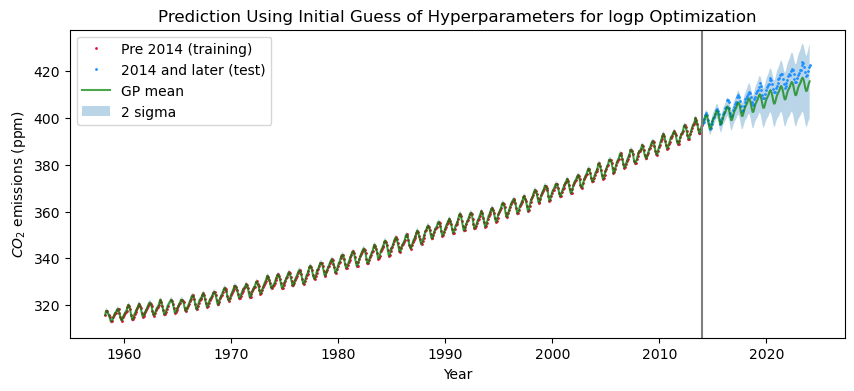

In [25]:
fig = plt.figure(figsize=(10,4))
plt.plot(x.values, y.values + mu_y, 'o', ms=1, color='crimson', label='Pre 2014 (training)')
plt.plot(xnew.values, ynew.values, 'o', ms=1, color='dodgerblue', label='2014 and later (test)')
plt.plot(df['Date'].values,mu + mu_y,'g',alpha=0.7,label='GP mean')
plt.fill_between(df['Date'].values,mu + mu_y - 2*np.diag(cov),
                 mu + mu_y + 2*np.diag(cov),alpha=0.3,label='2 sigma')
plt.legend()
plt.axvline(x=2014, color="grey")
plt.xlabel('Year')
plt.ylabel(r'$CO_2$ emissions (ppm)')
plt.title('Prediction Using Initial Guess of Hyperparameters for logp Optimization')
plt.show()

## References

1) P. Seshadri, “GP 101,” AE8803: MACHINE LEARNING WITH GAUSSIAN PROCESSES, psesh.github.io/ae8803/useful_codes/gp101.html (accessed Mar. 1, 2024). 
2) “Gradient descent,” Wikipedia, https://en.wikipedia.org/wiki/Gradient_descent (accessed Mar. 5, 2024). 
3) Madan Ram and Thomas Jungblut, “Gradient descent using python and numpy; Thomas Jungblut answer,” Stack Overflow, https://stackoverflow.com/questions/17784587/gradient-descent-using-python-and-numpy (accessed Mar. 5, 2024). 
4) Sachinruk, sachinruk, and Girish, “Trace of an inverse matrix,” Mathematics Stack Exchange, https://math.stackexchange.com/questions/391128/trace-of-an-inverse-matrix (accessed Mar. 7, 2024). 
5) C. E. Rasmussen and C. K. I. Williams, “Cholesky decomposition,” in Gaussian Processes for Machine Learning, Cambridge, MA: MIT Press, 2006, pp. 202–203 
6) P. Seshadri, “Gaussian marginals and Conditionals,” AE8803 | Georgia Institute of Technology, https://psesh.github.io/ae8803/useful_codes/gaussians.html (accessed Mar. 8, 2024). 
7) C. E. Rasmussen and C. K. I. Williams, “Mauna Loa Atmospheric Carbon Dioxide,” in Gaussian Processes for Machine Learning, Cambridge, MA: MIT Press, 2006, pp. 118-122
8) C. E. Rasmussen and C. K. I. Williams, “Algorithm 2.1,” in Gaussian Processes for Machine Learning, Cambridge, MA: MIT Press, 2006, pp. 19
9) P. Seshadri, “Hyperparameter Inference,” in AE8803 | Georgia Institute of Technology, Mar. 1, 2024 
10) C. E. Rasmussen and C. K. I. Williams, “Equation (4.9),” in Gaussian Processes for Machine Learning, Cambridge, MA: MIT Press, 2006, pp. 114
11) C. E. Rasmussen and C. K. I. Williams, “Theorem 4.2 (Mercer's Theorem),” in Gaussian Processes for Machine Learning, Cambridge, MA: MIT Press, 2006, pp. 96
12) C. E. Rasmussen and C. K. I. Williams, “Examples of Covariance Functions,” in Gaussian Processes for Machine Learning, Cambridge, MA: MIT Press, 2006, pp. 81-95
13) C. E. Rasmussen and C. K. I. Williams, “Rational Quadratic Covariance Function,” in Gaussian Processes for Machine Learning, Cambridge, MA: MIT Press, 2006, pp. 86-87
14) C. E. Rasmussen and C. K. I. Williams, “Equation (4.31),” in Gaussian Processes for Machine Learning, Cambridge, MA: MIT Press, 2006, pp. 92
15) C. E. Rasmussen and C. K. I. Williams, “Mauna Loa Atmospheric Carbon Dioxide,” in Gaussian Processes for Machine Learning, Cambridge, MA: MIT Press, 2006, pp. 122